<a href="https://colab.research.google.com/github/enriqueasegura/Fmethod/blob/master/Quantum_X_Write_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Study of Quantum Neural Networks to Simulate Quantum Systems

##Introduction
This colab notebook is a example of the use of quantum neural networks on quantum simulation. Using this optimization technique, it is possible to learn features of the quantum system, such as labeling of quantum states via stochastic gradient descent. By using SGD to change the phase-parameters present in the quantum circuit we can drive the system to optimal parameters that find the label of readout bit (in the case of Ising Model quantum circuit, and more generally in a measured qubit wire. 

This first part of the notebook:

1. We will use an example of quantum mechanics, the Stern Gerlach experiment, as a quantum circuit. 
2. We will introduce a random variable to this circuit. 
3. We will illustrate the circuit state as function of phase in a range of $[0, \pi]$.
4. We will show how through SGD the optimization algorithm finds the appropiate parameter to successfully label the measured qubit in either $ \uparrow$   or $ \downarrow$  state, which we will note here as 0-state and 1-state.

The second part of the notebook: 

1.  We will apply this optimization algorithm to the Ising Model represented by a quantum circuit. 
2.  We will show the correlation between the results learned with this algorithm and the measured energy of the Model. 


##Goal 

To illustrate the applications of optimization methods in a quantum circuit and how this technique can be scaled to explore its potential on working on the Ising Model. 

# A Very Quick Introduction to The Stern-Gerlach Experiment 

The Stern-Gerlach represents a quintessential experiment that shows the quantum spin as observed when a beam of particles are under the influence of a magnetic field.

![alt text](https://i.stack.imgur.com/BAbKC.pngg)


As seen in the image above, $ \uparrow$   or $ \downarrow$  are possible outcomes under this experiment. So let's think of the two states as the two possible labels of this state. This opens the following question: how can we find a way to find "tweak" the field so one state is favor over another? 

So first, let's just build a circuit using Cirq, but first let's bring all the necessary libraries to get this done!

In [202]:
import numpy as np
!pip install git+https://github.com/quantumlib/Cirq
  
import matplotlib.pyplot as plt
from pandas import DataFrame
import cirq
from cirq.ops import CNOT, TOFFOLI
from cirq import Simulator
import random
from sympy import Symbol
from cirq.circuits import InsertStrategy



  Cloning https://github.com/quantumlib/Cirq to /tmp/pip-req-build-qp_c7qzz
  Running command git clone -q https://github.com/quantumlib/Cirq /tmp/pip-req-build-qp_c7qzz
  Stored in directory: /tmp/pip-ephem-wheel-cache-w8mc05dl/wheels/c9/f4/ee/029123a49c5e2d75d08c2a9f937e207b88f045901db04632a7
Successfully built cirq


#Calling Cirq to Setup Quantum Environment

We define a circuit using Cirq to contain both the qubits needed to execute the quantum simulation as well as the quantum gates to build the desired system. 

In [230]:
circuit = cirq.Circuit()
qubit = cirq.LineQubit(0)
circuit.append(cirq.measure(qubit))
print(circuit)



0: ───M───


Above we have a simple circuit of line qubit intialized and measured. By repeating this process several times we can estimate the expected value of the operation in question.

To perform this task, we call a Simulator from the Cirq library.

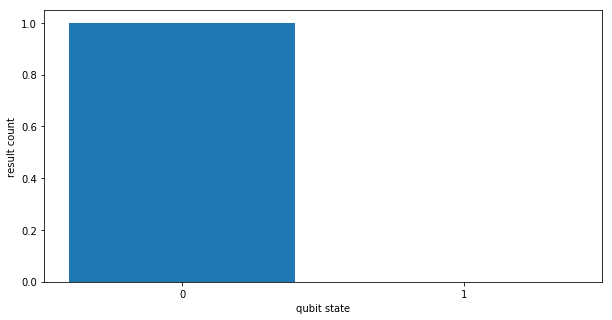

array([1., 0.])

In [231]:
simulator = cirq.Simulator()

results = simulator.run(circuit, repetitions=1)

plt.figure(figsize=(10,5))

cirq.plot_state_histogram(results)

When we inspect the individual results we find not the expected label values $\{ -1, 1\}$ , but rather boolean values, True\False: 

In [232]:
s_k, s_v= zip(*results.measurements.items())

print(s_v)

(array([[False]]),)


For our discussion, as shown in "Classification with Quantum Neural Networks on Near Term Processor", https://arxiv.org/abs/1802.06002,  it is convinient to switch to our label variables $z_i = 1 - 2b_i$ , where $z_i$ is the quantum label, and $b_i$ is the boolean parameter.

Taking that into consideration, we obtain the following:

In [233]:
label_values = 1 - 2*np.array(s_v).astype(np.int32)

print(label_values)

[[[1]]]


Thus, as seen above, following the research paper, we find the that |0> correspond to label value 1; accordingly |1> with label value -1. 

It is worth noting if the we want to frame this label appropiately into converting from boolean to spin values, that expression is realized through $s_i = 2b_i - 1$ as shown in "The Ising model: teaching an old problem new tricks",  https://www.dwavesys.com/sites/default/files/weightedmaxsat_v2.pdf

For the purposes of this notebook we will stick with framework established by Farhis and Neven.

#Building Stern-Gerlach as a Quantum Circuit

In order for us to simulate the Stern-Gerlach experiment, we will need the following two gates: 

1. Hadamard Gate: 

${\displaystyle H={\frac {1}{\sqrt {2}}}{\begin{bmatrix}1&1\\1&-1\end{bmatrix}}}$

2. Phase Shift Gate: 

${\displaystyle R_{\phi }={\begin{bmatrix}1&0\\0&e^{i\phi }\end{bmatrix}}}$

The $\phi$ parameter is important in the simulation of this circuit. For now we will show the setup and simulation of the circuit but further in the notebook we will go further than this. We will examine the effects of this parameter in the simulation.

The T-gate is an evaluated Phase Shift Gate at $\frac{\pi}{4}$.

0: ───H───T───H───M───


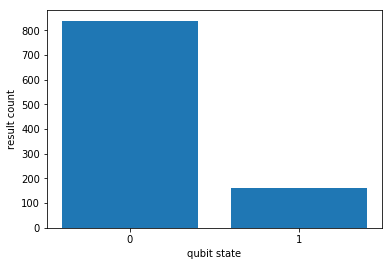

In [234]:
#This code represents a simple stern-gerlach circuit
#The goal is to observe that when the measurement is conducted
#The qubit state is no longer as depicted earlier in this notebook

circuit = cirq.Circuit()
qubit = cirq.LineQubit(0)

#Setting the series of quantum gates to create the circuit. 

circuit.append(cirq.H(qubit))
circuit.append(cirq.T(qubit))
circuit.append(cirq.H(qubit))
circuit.append(cirq.measure(qubit))
print(circuit)

#call the simulator to conduct the measurement

simulator = cirq.Simulator()

results = simulator.run(circuit, repetitions=1000)

cirq.plot_state_histogram(results)

#Preserve the measurement values
s_k, s_v= zip(*results.measurements.items())

label_values = 1 - 2*np.array(s_v).astype(np.int32)

As shown above, the quantum label of this qubit is no longer clear. Our goal for this part of the notebook is the following: how can we find a way to bring back the qubit to clear qubit state. 

First, let's show what the system looks like without the T-gate, and only focusing at one Hadamard gate a time. 

0: ───H───M───


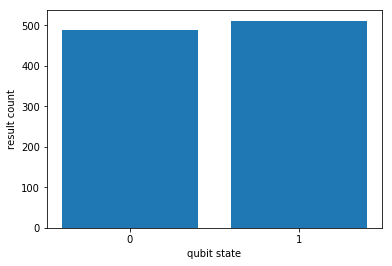

In [235]:
circuit = cirq.Circuit()
qubit = cirq.LineQubit(0)

#Setting the series of quantum gates to create the circuit. 

circuit.append(cirq.H(qubit))
circuit.append(cirq.measure(qubit))
print(circuit)

#call the simulator to conduct the measurement

simulator = cirq.Simulator()

results = simulator.run(circuit, repetitions=1000)

cirq.plot_state_histogram(results)

#Preserve the measurement values
s_k, s_v= zip(*results.measurements.items())

label_values = 1 - 2*np.array(s_v).astype(np.int32)

The above result should shows that the effects of the Hadamard gate as it mimicks the magnetic field the beam of particles (in our case, our line qubit)

Now, let's add the second Hadamard gate.

0: ───H───H───M───


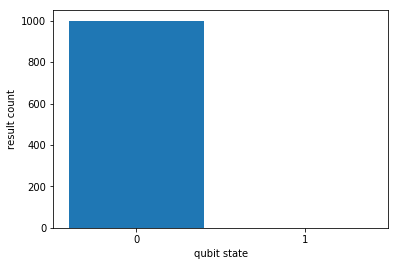

In [236]:
circuit = cirq.Circuit()
qubit = cirq.LineQubit(0)

#Setting the series of quantum gates to create the circuit. 

circuit.append(cirq.H(qubit))
circuit.append(cirq.H(qubit))
circuit.append(cirq.measure(qubit))
print(circuit)

#call the simulator to conduct the measurement

simulator = cirq.Simulator()

results = simulator.run(circuit, repetitions=1000)

cirq.plot_state_histogram(results)

#Preserve the measurement values
s_k, s_v= zip(*results.measurements.items())

label_values = 1 - 2*np.array(s_v).astype(np.int32)

This results shows us the following: 


1.   The Hadamard-driven effects are reversible by applying another Hadamard gate. 
2.   The  T-gate represents the best opportunity to "tweak" the circuit to recover a clear quantum label. 



In [0]:
#This code puts all of the examples above in one place

def stern_gerlach_example(type_number):
  #if it's 1, then it;'s just a measurement circuit'
  if type_number == 1:
    circuit = cirq.Circuit()
    qubit = cirq.LineQubit(0)
    circuit.append(cirq.measure(qubit))
    print(circuit)
    simulator = cirq.Simulator()

    results = simulator.run(circuit, repetitions=5)

    #plt.figure(figsize=(10,5))
    cirq.plot_state_histogram(results)
    
    s_k, s_v= zip(*results.measurements.items())

    label_values = 1 - 2*np.array(s_v).astype(np.int32)
    predicted_label = np.mean(label_values)
    
  #if it's 2, then it's circuit with only one Hadamard gate
  if type_number == 2:
    circuit = cirq.Circuit()
    qubit = cirq.LineQubit(0)

    #Setting the series of quantum gates to create the circuit. 

    circuit.append(cirq.H(qubit))
    circuit.append(cirq.measure(qubit))
    print(circuit)
    
    simulator = cirq.Simulator()

    results = simulator.run(circuit, repetitions=1000)
    
    #plt.figure(figsize=(10,5))
    cirq.plot_state_histogram(results)
    
    s_k, s_v= zip(*results.measurements.items())

    label_values = 1 - 2*np.array(s_v).astype(np.int32)
    predicted_label = np.mean(label_values)
  
  #if it's 3, then it's circuit with only two Hadamard gates
  if type_number == 3:
    circuit = cirq.Circuit()
    qubit = cirq.LineQubit(0)

    #Setting the series of quantum gates to create the circuit. 

    circuit.append(cirq.H(qubit))
    circuit.append(cirq.H(qubit))
    circuit.append(cirq.measure(qubit))
    print(circuit)
    
    simulator = cirq.Simulator()

    results = simulator.run(circuit, repetitions=1000)
    
    #plt.figure(figsize=(10,5))
    cirq.plot_state_histogram(results)
    
    s_k, s_v= zip(*results.measurements.items())

    label_values = 1 - 2*np.array(s_v).astype(np.int32)
    predicted_label = np.mean(label_values)
  
  #if it's 4, then it's circuit with only two Hadamard gates
  if type_number == 4:
    circuit = cirq.Circuit()
    qubit = cirq.LineQubit(0)

    #Setting the series of quantum gates to create the circuit. 

    circuit.append(cirq.H(qubit))
    circuit.append(cirq.T(qubit))
    circuit.append(cirq.H(qubit))
    circuit.append(cirq.measure(qubit))
    print(circuit)
    
    simulator = cirq.Simulator()

    results = simulator.run(circuit, repetitions=1000)
    
    #plt.figure(figsize=(10,5))
    cirq.plot_state_histogram(results)
    
    s_k, s_v= zip(*results.measurements.items())

    label_values = 1 - 2*np.array(s_v).astype(np.int32)
    predicted_label = np.mean(label_values)
  return predicted_label
    

#Loss Function in a Quantum Circuit. 

Farhi and Neven's paper show us a way forward to find a quantum label: 


1.  The measurement outcome of this quantum circuit represents predicted, since it is not certain, label value. This value is bounded by a real value between $[-1,1]$, which is consistent with the labels for this quantum system. 
2.   Having this predicted label value, we can use this value to find the $\phi$ that brings the predicted label closer to the true label. We will use $P$ to denote this value.

We define the predicted label value as the average value of all measurement operation in the circuit. So, let's see what the predicted measured value looks like for examples we have shown




Measurement Circuit:
0: ───M───


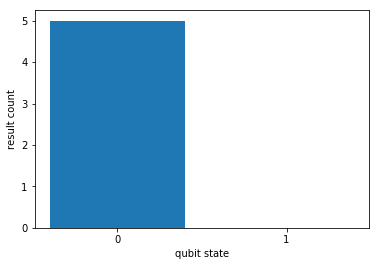

Predicted Label:  1.0
--------
--------
Hadamard Circuit:
0: ───H───M───


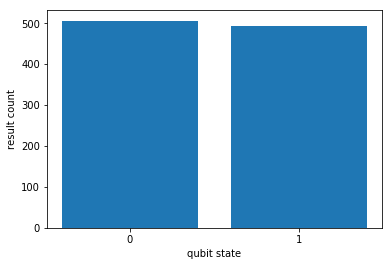

Predicted Label:  0.012
--------
--------
H-H Circuit:
0: ───H───H───M───


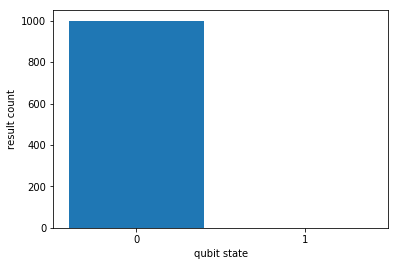

Predicted Label:  1.0
--------
--------
H-T-H Circuit:
0: ───H───T───H───M───


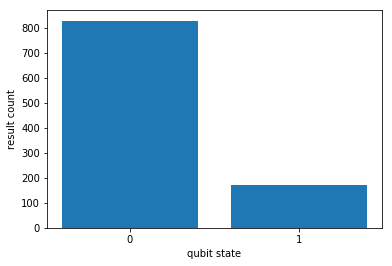

Predicted Label:  0.658


In [237]:
#example 1 (Only a Measurement Gate in the circuit)
print('Measurement Circuit:')
case_1 = stern_gerlach_example(1)
print('Predicted Label: ', case_1)

print('--------')
print('--------')

#example 2 (Only One Hadamard Gate in the circuit)
print('Hadamard Circuit:')
case_2 = stern_gerlach_example(2)
print('Predicted Label: ', case_2)

print('--------')
print('--------')


#example 3 (Only Two Hadamard Gates in the circuit)
print('H-H Circuit:')
case_3 = stern_gerlach_example(3)
print('Predicted Label: ', case_3)

print('--------')
print('--------')

#example 4 (H-T-H Circuit)
print('H-T-H Circuit:')
case_4 = stern_gerlach_example(4)
print('Predicted Label: ', case_4)

#Building the Stern-Gerlach Circuit


In [238]:
#This circuit brings together the previous work we have done in this notebook. 
#And adds the parameter to the phase gate.

def stern_gerlach_circuit(random_phase_gate_parameter, printout_message):
  circuit = cirq.Circuit()
  qubit = cirq.LineQubit(0)
  
  circuit.append(cirq.H(qubit))
  
  #We take the phase parameter to adjust the circuit
  
  phase_gate_variated = cirq.ZPowGate(exponent=random_phase_gate_parameter)
  circuit.append(phase_gate_variated(qubit))
  
  circuit.append(cirq.H(qubit))
  
  circuit.append(cirq.measure(qubit, key ='q0'))
  
  if printout_message == 'yes':
    print(circuit)
  return circuit


#using random_phase_parameter =1 
circuit_before_optimization = stern_gerlach_circuit(1, 'yes')

0: ───H───Z───H───M('q0')───


#Loss Function and Starting to Think About Stochastic Gradient Descent

Having a way to measure the predicted label in the quantum circuit, we the next step to start working on our problem is to define a loss function: 

loss($\vec{\phi}$, $z$) = 1 - l($z$) $P(\phi)$, where l($z$) represents the correct label of the quantum state. 

This equation represents the sample loss as a function of $\phi$ in the circuit. It is worth noting that by inspection one can see that when the loss tends to zero, we have the following at loss = 0.

1.   If the correct label is 1, then the predicted label would be near 1 and with a positive sign.
2.   If the correct label is -1, then the predicted label would be near -1 and with a negative sign.

It may seem a like a silly thing to check, but this gives us a sense that the loss function then bounded in the range $[0,1]$. However, this sanity check explains the following point in Farhis et. al.  : since l($z$) can only be -1 or +1, then we have the following: 

$P(\phi)$ = l($z$). 

This is important as for the implementation of SGD we will use $P(\phi)$  to drive the optimization process. 

Another note that is significant is the following: we can represent the l($z$) in a different form from the information stated above: 

loss($\vec{\phi}$, $z$) = 1 - $P(\phi)^2$

And we can represent $P(\phi)^2$ as $(iP(\phi))^2$, which yields the following: 

loss($\vec{\phi}$, $z$) = 1 + $(iP(\phi))^{2}$

The reason behind this slight change is to have a clear thread between the original statement of the loss function and the subsequent exposition of SGD. This was not included in the paper. I add this to make very clear for anyone who is not an expert in this subject. 

Having this equation in this form, we can take its gradient: 

$\frac{d loss(\vec{\phi}, z) }{d\phi} = 2iP(\phi)$, which we will refer to it as $g$.

Following Google's Paper, we can express the loss function as follows:

loss($\vec{\phi} + \gamma g$, $z$) = loss($\vec{\phi}$, $z$) +$ \gamma g^2$ + $O(\gamma^2)$

where for loss =0, $\gamma = \frac{loss(\vec{\phi}, z) }{g^2}$,

Putting all this together, we can describe the optimization process with SGD as: 

$\phi_{k+1} = \phi_k - r\gamma g $, where $r$ is the learning rate, which represents the step size used to calculate the new parameter $\phi_{k+1}$.

#Optimizing SGD


For the purposes of this notebook we will use the Adam implementatio of SGD, "ADAM: A METHOD FOR STOCHASTIC OPTIMIZATION", found in https://arxiv.org/pdf/1412.6980.pdf

Below are the equations that we will use to find optimal $\phi$ to minimize the loss function:

${\displaystyle m_{w}^{(t+1)}\leftarrow \beta _{1}m_{w}^{(t)}+(1-\beta _{1})\nabla _{w}L^{(t)}}$

${\displaystyle v_{w}^{(t+1)}\leftarrow \beta _{2}v_{w}^{(t)}+(1-\beta _{2})(\nabla _{w}L^{(t)})^{2}}$

${\displaystyle {\hat {m}}_{w}={\frac {m_{w}^{(t+1)}}{1-(\beta _{1})^{t+1}}}}$

${\displaystyle {\hat {v}}_{w}={\frac {v_{w}^{(t+1)}}{1-(\beta _{2})^{t+1}}}}$

${\displaystyle w^{(t+1)}\leftarrow w^{(t)}-\eta {\frac {{\hat {m}}_{w}}{{\sqrt {{\hat {v}}_{w}}}+\epsilon }}}$

From the OpenAI paper, one note: use use $\phi$ instead of $w$ or $\theta$ to implement this algorithm; the latter is the standard notation for weights in machine learning research. We have used the following tuning parameters to implement this algorithm:
  

1. First moment vector (gradient_moment) = 0 
2. Second moment vector (momentum_moment)= 0
3. Count (Timestep) = 1
4. $\beta_1$ = 0.9
5. $\beta_2$ = .999
6 $\epsilon$ = $10^{-8}$
7. Learning Rate, $r$ (in Farhi's paper), $\alpha$ in OpenAI's paper = 0.01.



In [0]:
def stern_gerlach_ml(learning_rate, random_t_parameter):
  
  #this list keeps a record of the evolution of phi as optimization searches for
  #loss minimum. 
  weight_arr = []
  
  #this list keeps track of the loss function as it is being minimized.
  loss_arr =[]
  
  grad_arr =[]
  label_arr =[]
  
  zero_state_arr =[]
  one_state_arr =[]
  
  
  status = 'not done'
  count =1
  
  #code to implement Learning Rate Optimization
  #We used OpenAI's Adam paper as a reference.
  
  gradient_moment = 0 
  momentum_moment =0
  beta_1 = 0.9
  beta_2 = 0.999
  smoothing_epsilon = 1e-8
  learning_rate = 0.01
  
  while status == 'not done':
    #get results
    #print('current count: ', count)
    #print('current weight:', random_t_parameter)
    
    weight_arr.append(random_t_parameter)
    dummy_stern_gerlach = stern_gerlach_circuit(random_t_parameter, 'no')
    
    results = simulator.run(dummy_stern_gerlach, repetitions=1000)
    
    count_results = results.histogram(key='q0')
  
    zero_state_arr.append(count_results[0]/1000)
    one_state_arr.append(count_results[1]/1000)
    
    s_k, s_v= zip(*results.measurements.items())
  
  
    current_state_values = 1 - 2*np.array(s_v).astype(np.int32)
    
    #current_state_values = 2*np.array(s_v).astype(np.int32)-1
    
    current_predicted_label_value = np.mean(current_state_values)
    label_arr.append(current_predicted_label_value)
  
    current_loss_value = 1 - np.square(current_predicted_label_value)
    #print('current loss: ', current_loss_value)
    loss_arr.append(current_loss_value)
    
    current_gradient_value = 2*current_predicted_label_value
    grad_arr.append(current_gradient_value)
    
    current_grad_square = np.square(current_gradient_value)

    
    if count > 5000:
      print('count is way too much!')
      status = 'done'
      break
    
    elif np.abs(current_loss_value) < 1e-6:
      status = 'done'
      cirq.plot_state_histogram(results)   
      print('Done! Final Weight: ',weight_arr[-1])

    else:
      
      next_gradient_moment = beta_1*gradient_moment +(1-beta_1)*current_gradient_value
      #biased corrected first estimate 
      
      biased_gradient_moment = next_gradient_moment / (1- beta_1**count)
      
      #swap the value for the next iteration
      gradient_moment = next_gradient_moment 
      
      next_momentum_moment = beta_2*momentum_moment + (1-beta_2)*np.square(current_gradient_value)
      
      #biased corrected first estimate for momentum 
      biased_momentum_moment = next_momentum_moment / (1 - beta_2**count)
      
      #another swap
      momentum_moment = next_momentum_moment
      
      #adjust the weights to find optimal parameters 
      random_t_parameter= random_t_parameter -  learning_rate* biased_gradient_moment / (np.sqrt(biased_momentum_moment) + smoothing_epsilon)
      
      count = count +1

  return(weight_arr, loss_arr, grad_arr, weight_arr[-1], label_arr, zero_state_arr, one_state_arr)

Initial Phase Gate Parameter:  0.6710133582011558
0: ───H───Z^0.671───H───M('q0')───


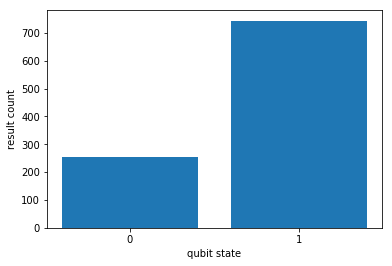

array([256., 744.])

In [240]:
#This represents the random value between [0,pi]

phase_zgate = np.random.uniform(0,1)
print('Initial Phase Gate Parameter: ', phase_zgate)
#create a circuit before

circuit_before_optimization = stern_gerlach_circuit(phase_zgate, 'yes')

#simulate 

results_before_optimization = simulator.run(circuit_before_optimization, repetitions=1000)

cirq.plot_state_histogram(results_before_optimization)

Initial Phase Gate Parameter:  0.6710133582011558


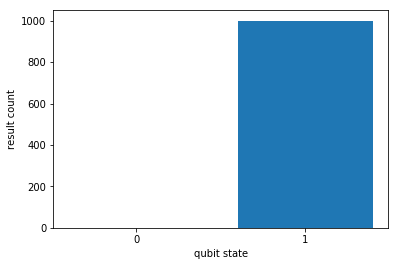

Done! Final Weight:  0.9651918090639622


In [241]:
print('Initial Phase Gate Parameter: ', phase_zgate)

circuit_with_ml = stern_gerlach_ml(0.01, phase_zgate)

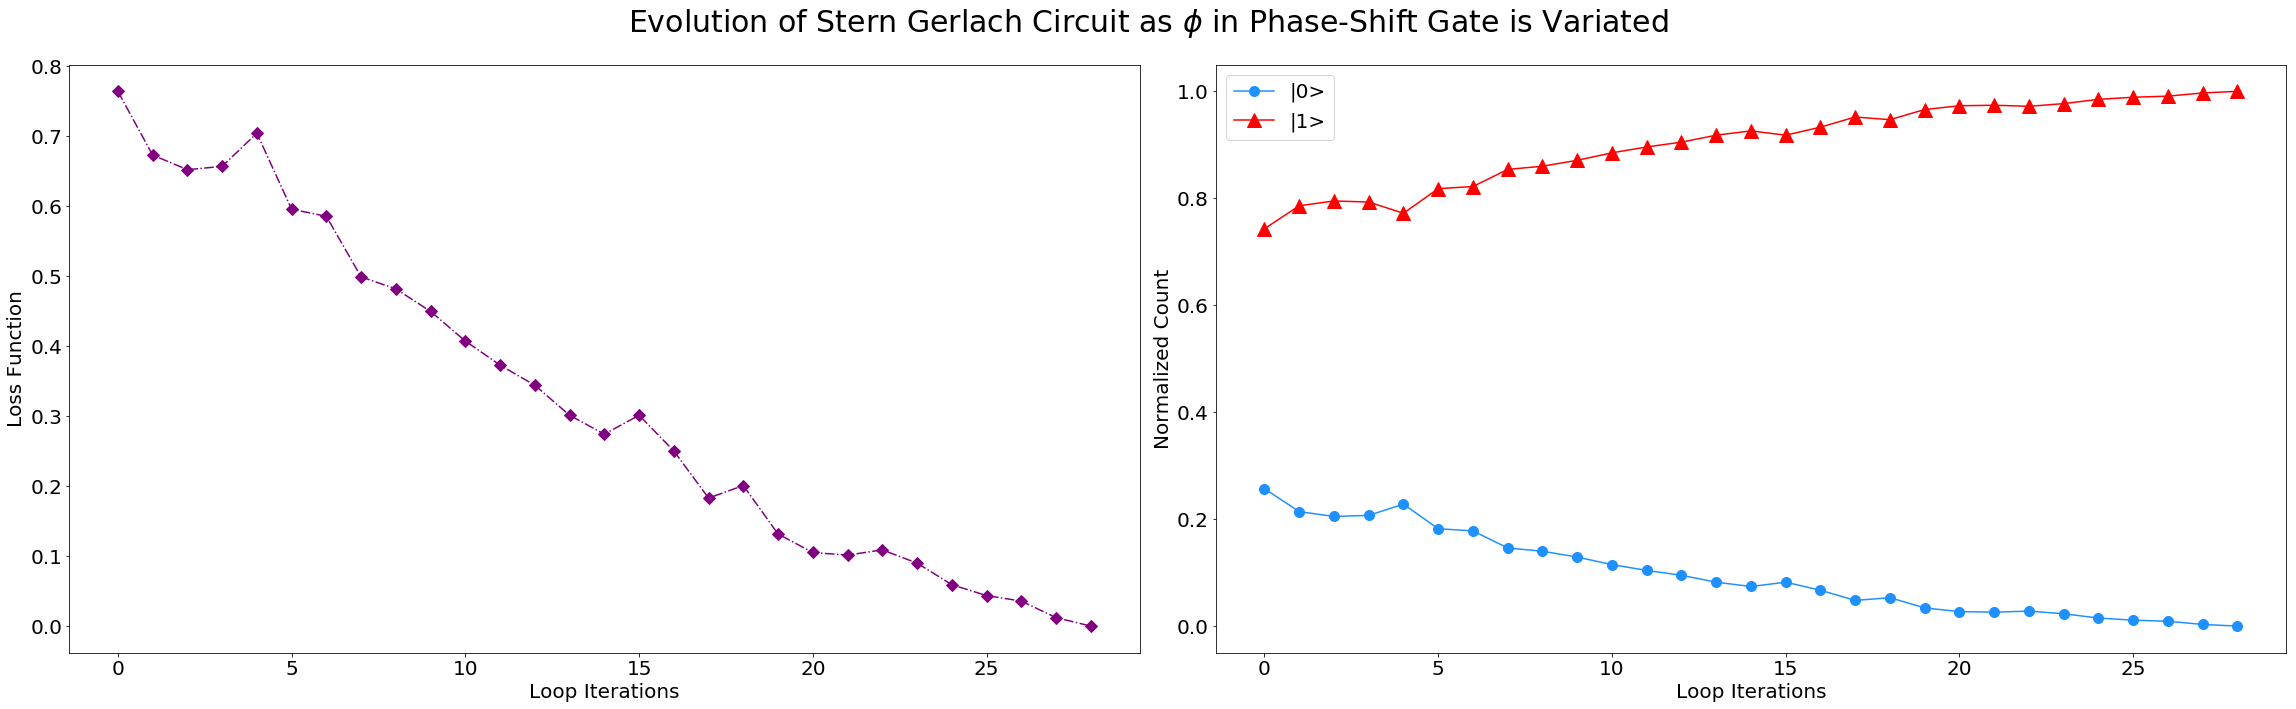

In [242]:
plot_ml = plt.figure(figsize=(32,10))
plt.subplot(121)
plt.tick_params(labelsize=20)
plt.plot(circuit_with_ml[1], color='purple', linestyle='-.', marker='D', markersize=8)

plt.ylabel('Loss Function', fontsize=20)
plt.xlabel('Loop Iterations', fontsize=20)

plt.subplot(122)

plt.plot(circuit_with_ml[5], label = '|0>', linestyle='-', marker ='o', markersize=10, color='dodgerblue')
plt.plot( circuit_with_ml[6], label = '|1>', linestyle='-', marker ='^', markersize=14, color='red')

plt.legend(loc='best', fontsize=20)
plt.tick_params(labelsize=20)

plt.xlabel('Loop Iterations', fontsize=20)
plt.ylabel('Normalized Count', fontsize=20)

plt.suptitle(r'Evolution of Stern Gerlach Circuit as $\phi$ in Phase-Shift Gate is Variated', fontsize=30)
plt.tick_params(labelsize=20)

plt.tight_layout()

plt.subplots_adjust(top=.9)

#Exploring Results of Quantum Simulation of Stern-Gerlach 

By applying the fundamental ideas behind Farhi and Neven's paper, it is clear that one can use the predicted label of the qubit to modify the circuit using SGD to minimize the loss funcition. In doing so, we can see those results on the fourth plot dealing with normalized counts and changes in $\phi$. As the phase is changed on the variated gate, we can see how the populations between |0> and |1> change leading to the final result: a clear leading state in the circuit. 

However, this is not enough. We have to inspect the circuit in more detail to see whether this result is valid. In order for us to do that, we will show the evolution of this quantum circuit as it is variated between $[0,\pi]$. 

In [0]:
#This is a Count Counter, a function to inspect the circuit and retrieve 
#the state of the circuit.

def count_counter(parameter_for_gate):
  circuit_test = stern_gerlach_circuit(parameter_for_gate, 'no')
  results_test =  simulator.run(circuit_test, repetitions=1000)
  
  count_results = results_test.histogram(key='q0')
  
  label_zero_ket = count_results[0]
  label_one_ket = count_results[1]
  
  s_k, s_v= zip(*results_test.measurements.items())
  current_state_values = 1 - 2*np.array(s_v).astype(np.int32)

  current_predicted_label_value = np.mean(current_state_values)
  
  current_gradient_value = 2*current_predicted_label_value
  
  current_loss_value = 1 - np.square(current_predicted_label_value)
  
  #calculate energy
  #value of spin for |0> is of -1, |1> is 1 for the label. 

  return(label_zero_ket, label_one_ket, current_gradient_value, current_loss_value, current_predicted_label_value)


#This code allows us to retrieve the figures of merit to plot the state of the circuit
#as it is variated 
range_phase = np.arange(0, 1.01, 0.01)

zero_ket_count = []
one_ket_count = []
grad_arr = []
loss_arr = []
pred_label_arr = []

for phi in range_phase:
  zero_ket_count.append(count_counter(phi)[0]/1000)
  one_ket_count.append(count_counter(phi)[1]/1000)
  grad_arr.append(count_counter(phi)[2])
  loss_arr.append(count_counter(phi)[3])
  pred_label_arr.append(count_counter(phi)[4])

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

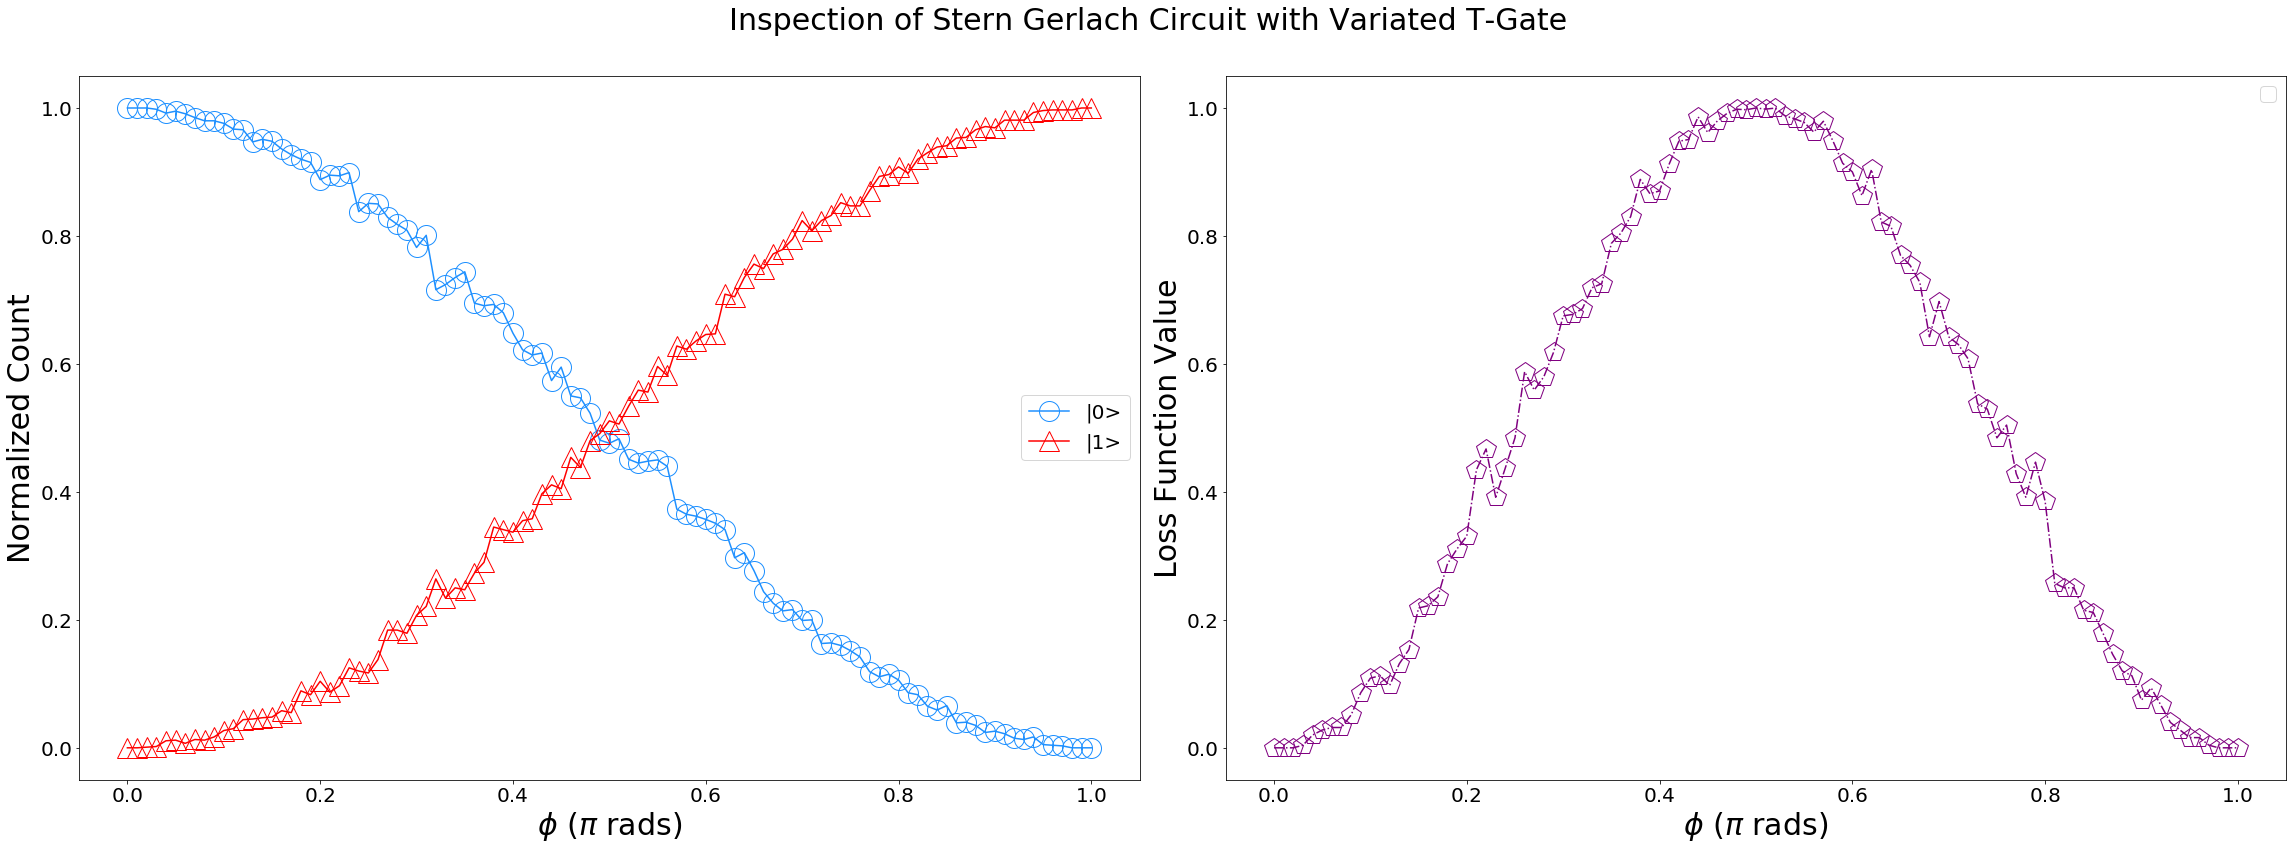

In [244]:
plt.figure(342)

plt.figure(figsize=(32,12))  

plt.subplot(121)
plt.plot(range_phase,zero_ket_count, marker = 'o', markersize=20,markerfacecolor="None", label = '|0>', color='dodgerblue')
plt.plot(range_phase,one_ket_count, marker = '^',markersize=20,markerfacecolor='None',  label = '|1>', color='red')


plt.legend(loc='best', fontsize=20)
plt.tick_params(labelsize=20)

plt.ylabel('Normalized Count', fontsize=30)
plt.xlabel(r'$\phi$ ($\pi$ rads)', fontsize=30)


plt.subplot(122)
plt.plot(range_phase, loss_arr, color ='purple', linestyle ='-.', marker = 'p',markerfacecolor="None", markersize=20)

plt.ylabel('Loss Function Value', fontsize=30)
plt.xlabel(r'$\phi$ ($\pi$ rads)', fontsize=30)
plt.legend(loc='best', fontsize=20)
plt.tick_params(labelsize=20)


plt.suptitle('Inspection of Stern Gerlach Circuit with Variated T-Gate', fontsize=30)

plt.tight_layout()
plt.subplots_adjust(top=.9)

#Inspecting Stern-Gerlach Inspection

Two important points to take away from this plot: 

1.   We can see on the figure on the left that for the lower $\phi$ values, the measurement values will be dominated by |1> state, and as we move to the other end of the range we see the opposite. 

While this point may seem silly, it is an important one. We want to have a sense of predictability of the impact of the T-gate in the measurement, which prompts the next point.

2.   On the other figure to the left, it's clear that the loss function is at a minimum at the both $\phi = 0, \pi$. At zero, the dominant state is |0>, and at $\pi$ |1>. 

Again, it may seem very simple, but this is an important result. This allows to have a degree of predictability when understanding for example, if you have a random $\phi$ that is greater than 0.5, then the algorithm will bring the system to its local minimum at 1. 

This also is a benchmark to evaluate the loss function - why a simulation might be yielding non physical results. 

This inspection validates that SGD fines the gate parameter that brings the system to a clear quantum state. 

This information can be used to prepare a quantum state with the consideration of the target state one intends on bringing this system to contain. 

#Bringing Optimization Algorithm to Ising Model


Having this algorithm and understanding its mechanics and its application to understand quantum system, the next step will be bring the original problem posed by Farhi and Neven's paper: can we find the optimal parameters needed to get the predicted quantum label of the readout qubit to nearest to its real label?

${\displaystyle H(\sigma )=\sum _{\langle i~j\rangle }J_{ij}\sigma _{i}\sigma _{j} +\sum _{j}h_{j}\sigma _{j}}$

For us to develop this hamiltonian into a circuit, we will need create the interaction fields between the qubits and by an external, which you will see below

We will use follow the same approach and code that Cirq used for their tutorial, but we will modify the circuit to accommodate what is needed to apply the optimization algorithm shown earlier in this notebook.

#Ising Model Implementation

In [0]:
#The first part is using Google's Code. 

def rand2d(rows, cols):
    return [[random.choice([+1, -1]) for _ in range(rows)] for _ in range(cols)]

def random_instance(length):
    # transverse field terms
    h = rand2d(length, length)
    # links within a row
    jr = rand2d(length, length - 1)
    # links within a column
    jc = rand2d(length - 1, length)
    return (h, jr, jc)

def rot_x_layer(length, half_turns):
    """Yields X rotations by half_turns on a square grid of given length."""
    rot = cirq.XPowGate(exponent=half_turns)
    for i in range(length):
        for j in range(length):
            yield rot(cirq.GridQubit(i, j))

def rot_z_layer(h, half_turns):
    """Yields Z rotations by half_turns conditioned on the field h."""
    gate = cirq.ZPowGate(exponent=half_turns)
    for i, h_row in enumerate(h):
        for j, h_ij in enumerate(h_row):
            if h_ij == 1:
                yield gate(cirq.GridQubit(i, j))
                
def rot_11_layer(jr, jc, half_turns):
    """Yields rotations about |11> conditioned on the jr and jc fields."""
    gate = cirq.CZPowGate(exponent=half_turns)    
    for i, jr_row in enumerate(jr):
        for j, jr_ij in enumerate(jr_row):
            if jr_ij == -1:
                yield cirq.X(cirq.GridQubit(i, j))
                yield cirq.X(cirq.GridQubit(i + 1, j))
            yield gate(cirq.GridQubit(i, j),
                       cirq.GridQubit(i + 1, j))
            if jr_ij == -1:
                yield cirq.X(cirq.GridQubit(i, j))
                yield cirq.X(cirq.GridQubit(i + 1, j))
            
    for i, jc_row in enumerate(jc):
        for j, jc_ij in enumerate(jc_row):
            if jc_ij == -1:
                yield cirq.X(cirq.GridQubit(i, j))
                yield cirq.X(cirq.GridQubit(i, j + 1))
            yield gate(cirq.GridQubit(i, j),
                       cirq.GridQubit(i, j + 1))
            if jc_ij == -1:
                yield cirq.X(cirq.GridQubit(i, j))
                yield cirq.X(cirq.GridQubit(i, j + 1))
                
def one_step(h, jr, jc, x_half_turns, h_half_turns, j_half_turns):
    length = len(h)
    yield rot_x_layer(length, x_half_turns)
    yield rot_z_layer(h, h_half_turns)
    yield rot_11_layer(jr, jc, j_half_turns)


def energy_func(length, h, jr, jc):
    def energy(measurements):
        # Reshape measurement into array that matches grid shape.
        meas_list_of_lists = [measurements[i * length:(i + 1) * length]
                              for i in range(length)]
        # Convert true/false to +1/-1.
        pm_meas = 1 - 2 * np.array(meas_list_of_lists).astype(np.int32)

        tot_energy = np.sum(pm_meas * h)
        for i, jr_row in enumerate(jr):
            for j, jr_ij in enumerate(jr_row):
                tot_energy += jr_ij * pm_meas[i, j] * pm_meas[i + 1, j]
        for i, jc_row in enumerate(jc):
            for j, jc_ij in enumerate(jc_row):
                tot_energy += jc_ij * pm_meas[i, j] * pm_meas[i, j + 1]
        return tot_energy
    return energy


def obj_func(result):
    energy_hist = result.histogram(key='x', fold_func=energy_func(3, h, jr, jc))
    return np.sum([k * v for k,v in energy_hist.items()]) / result.repetitions

#From here on out I am using the above shown code to customize it to fit the problem in Farhi's paper. 
  
#The two functions below are intended to build the Ising Model:
# Label Circuit function builds the model adding the measurement gate in the readout-bit. 
# Energy Circuit funcion builds the model as intended by Cirq's tutorial 

def Ising_Model_Hamiltonian_Quantum_Circuit_Label(length, h, jr, jc, random_xlayer_param, random_z_layer_param, random_rot_11_layer_param):
  circuit = cirq.Circuit()
  qubits = [cirq.GridQubit(i, j) for i in range(length) for j in range(length)]
  circuit.append(one_step(h, jr, jc, random_xlayer_param, random_z_layer_param, random_z_layer_param))
  circuit.append(cirq.measure(qubits[-1], key='x'),strategy=InsertStrategy.NEW)
  return circuit

def Ising_Model_Hamiltonian_Quantum_Circuit_Energy(length, h, jr, jc, random_xlayer_param, random_z_layer_param, random_rot_11_layer_param):
  circuit = cirq.Circuit()
  qubits = [cirq.GridQubit(i, j) for i in range(length) for j in range(length)]
  circuit.append(one_step(h, jr, jc, random_xlayer_param, random_z_layer_param, random_z_layer_param))
  circuit.append(cirq.measure(*qubits, key='x'))
  return circuit


#This is the classical implementation of SGD. 
#This is for illustration purposes of how to apply SGD to this system. 

def Ising_Model_Params_Optimizier_Label(length, h, jr, jc, learning_rate, random_xlayer_param, random_z_layer_param, random_rot_11_layer_param):
  xlayer_arr =[]
  zlayer_arr =[]
  rot_11_layer_arr =[]
  
  gradient_arr = []
  loss_arr =[]
  label_arr =[]
  
  zero_state_arr =[]
  one_state_arr =[]
  
  energy_arr = []
  status = 'not done'
  count = 1
  
  while status == 'not done':
    #print('count: ', count)    
    #print('current seed parameters: ', random_xlayer_param, random_z_layer_param, random_rot_11_layer_param)
    
    xlayer_arr.append(random_xlayer_param)
    zlayer_arr.append(random_z_layer_param)
    rot_11_layer_arr.append(random_rot_11_layer_param)
    
    test_circuit_label = Ising_Model_Hamiltonian_Quantum_Circuit_Label(length, h, jr, jc, random_xlayer_param, random_z_layer_param, random_rot_11_layer_param)
    
    #make energy circuit 
    test_circuit_energy = Ising_Model_Hamiltonian_Quantum_Circuit_Energy(length, h, jr, jc, random_xlayer_param, random_z_layer_param, random_rot_11_layer_param)
    
    results_energy = simulator.run(test_circuit_energy, repetitions=1000)
    
    energy_arr.append(obj_func(results_energy))
    
    results = simulator.run(test_circuit_label, repetitions=1000)
    s_k, s_v= zip(*results.measurements.items())
    #check for the loss function at this point
    #convert from 0,1 state count to -1,1
    
    current_state_values = 1 - 2*np.array(s_v).astype(np.int32)

    current_predicted_label_value = np.mean(current_state_values)
    label_arr.append(current_predicted_label_value)
  
    current_loss_value = 1 - np.square(current_predicted_label_value)
    loss_arr.append(current_loss_value)
    #print('current loss: ', current_loss_value)
    loss_arr.append(current_loss_value)
    
    current_gradient_value = 2*current_predicted_label_value
    gradient_arr.append(current_gradient_value)
    
    current_grad_square = np.square(current_gradient_value)
    
    if count > 5000:
      print('count is way too much!')
      status = 'done'
      break
    
    elif np.abs(current_loss_value) < 1e-6:
      status = 'done'
      cirq.plot_state_histogram(results)   
      
    random_xlayer_param = random_xlayer_param -  learning_rate*current_loss_value*current_gradient_value / np.square(current_gradient_value)
    random_z_layer_param = random_z_layer_param - learning_rate*current_loss_value*current_gradient_value / np.square(current_gradient_value)
    random_rot_11_layer_param = random_rot_11_layer_param - learning_rate*current_loss_value*current_gradient_value / np.square(current_gradient_value)
    
    #cirq.plot_state_histogram(results)
    count = count +1
    #print('current loss: ',current_loss_value)
    
  optimal_values = [xlayer_arr[-1],zlayer_arr[-1], rot_11_layer_arr[-1]]
  print('Optimal values:', optimal_values)
  print('Done with Regular SGD!')
  return(xlayer_arr, zlayer_arr, rot_11_layer_arr, loss_arr,gradient_arr, label_arr, energy_arr, optimal_values)


# This is the ADAM implementation of SGD. 
# I found through developing this simulation that it reduces running 
# time significantly. 
# For specific information regarding the algorithm, please see OpenAI's paper
# mentioned in this notebook. 

def Ising_Model_Params_Optimizier_Adam(length, h, jr, jc, random_xlayer_param, random_z_layer_param, random_rot_11_layer_param):
  
  xlayer_arr =[]
  zlayer_arr =[]
  rot_11_layer_arr =[]
  
  gradient_arr = []
  loss_arr =[]
  label_arr =[]
  
  energy_arr = []
  
  zero_state_arr =[]
  one_state_arr =[]
  
  status = 'not done'
  count = 1
  
  #code to implement Learning Rate Optimization
  
  gradient_moment = 0 
  momentum_moment =0
  beta_1 = 0.9
  beta_2 = 0.999
  smoothing_epsilon = 1e-8
  learning_rate = 0.01
  
  count = 1
  
  while status == 'not done':
    #get results
    #print('current count: ', count)
    #print('current weight:', random_t_parameter)
    
    xlayer_arr.append(random_xlayer_param)
    zlayer_arr.append(random_z_layer_param)
    rot_11_layer_arr.append(random_rot_11_layer_param)  
    
    test_circuit_label = Ising_Model_Hamiltonian_Quantum_Circuit_Label(length, h, jr, jc, random_xlayer_param, random_z_layer_param, random_rot_11_layer_param)
    
    #make energy circuit 
    test_circuit_energy = Ising_Model_Hamiltonian_Quantum_Circuit_Energy(length, h, jr, jc, random_xlayer_param, random_z_layer_param, random_rot_11_layer_param)
    
    results_energy = simulator.run(test_circuit_energy, repetitions=1000)
    
    energy_arr.append(obj_func(results_energy))
    
    results = simulator.run(test_circuit_label, repetitions=1000)
    
    #check the state population
    
    count_results = results.histogram(key='x')
  
    zero_state_arr.append(count_results[0]/1000)
    one_state_arr.append(count_results[1]/1000)
    
    s_k, s_v= zip(*results.measurements.items())
    
    #check for the loss function at this point
    #convert from 0,1 state count to -1,1
    
    current_state_values = 1 - 2*np.array(s_v).astype(np.int32)
    
    current_predicted_label_value = np.mean(current_state_values)
    
    label_arr.append(current_predicted_label_value)
  
    current_loss_value = 1 - np.square(current_predicted_label_value)
    loss_arr.append(current_loss_value)
    
    current_gradient_value = 2*current_predicted_label_value
    gradient_arr.append(current_gradient_value)
    
    current_grad_square = np.square(current_gradient_value)
    
    if count > 5000:
      print('count is way too much!')
      status = 'done'
      break
    
    elif np.abs(current_loss_value) < 1e-6:
      status = 'done'
      cirq.plot_state_histogram(results)       

    else:
      
      next_gradient_moment = beta_1*gradient_moment +(1-beta_1)*current_gradient_value
      #biased corrected first estimate 
      
      biased_gradient_moment = next_gradient_moment / (1- beta_1**count)
      
      #swap the value for the next iteration
      gradient_moment = next_gradient_moment 
      
      next_momentum_moment = beta_2*momentum_moment + (1-beta_2)*np.square(current_gradient_value)
      
      #biased corrected first estimate for momentum 
      biased_momentum_moment = next_momentum_moment / (1 - beta_2**count)
      
      #another swap
      momentum_moment = next_momentum_moment
      
      #adjust the weights to find optimal parameters 
      random_xlayer_param = random_xlayer_param -  learning_rate* biased_gradient_moment / (np.sqrt(biased_momentum_moment) + smoothing_epsilon)
      random_z_layer_param = random_z_layer_param - learning_rate* biased_gradient_moment / (np.sqrt(biased_momentum_moment) + smoothing_epsilon)
      random_rot_11_layer_param = random_rot_11_layer_param - learning_rate* biased_gradient_moment / (np.sqrt(biased_momentum_moment) + smoothing_epsilon)
      
      count = count +1

  optimal_values = [xlayer_arr[-1],zlayer_arr[-1], rot_11_layer_arr[-1]]
  print('Optimal values:', optimal_values)
  print('Done with Optimization Algorithm!')
  return(xlayer_arr, zlayer_arr, rot_11_layer_arr, loss_arr,gradient_arr, label_arr, energy_arr, zero_state_arr, one_state_arr, optimal_values)

#Let's setup the Ising Model Simulation

In [246]:
#these parameters make the fields for the hamiltonian. These are global variables 
h, jr, jc = random_instance(3)
#h =  [ [0,0,0], [0,0,0], [0,0,0]]
length=3

print('transverse fields: {}'.format(h))
print('row j fields: {}'.format(jr))
print('column j fields: {}'.format(jc))
print('Length circuit: ', length)


#declare the simulator to simulate the intended circuit
simulator = cirq.Simulator()

transverse fields: [[1, 1, 1], [-1, 1, 1], [1, -1, -1]]
row j fields: [[-1, 1, 1], [-1, 1, -1]]
column j fields: [[1, 1], [-1, -1], [-1, 1]]
Length circuit:  3


Just like with Stern-Gerlach, we need random parameters to be used to seed the circuit before we start treating it. 

In [272]:
xlayer_p, zlayer_p, rot_layer_p = np.random.uniform(0,1), np.random.uniform(0,1), np.random.uniform(0,1)

print('Initial Phase Parameters: ', xlayer_p, zlayer_p, rot_layer_p)


Initial Phase Parameters:  0.4879698133606518 0.7707392221782763 0.4903147157900696


Putting all together, we can represent the Ising Model's hamiltonian as a quantum circuit using Cirq:

In [273]:
test_circuit = Ising_Model_Hamiltonian_Quantum_Circuit_Energy(length, h, jr, jc, xlayer_p, zlayer_p, rot_layer_p)

print(test_circuit)

                               ┌──────────────┐   ┌────────┐   ┌────────┐             ┌────────┐
(0, 0): ───X^0.488───Z^0.771────X──────────────────@────────────X───────────@────────────────────────────────────────────────────────────────────M('x')───
                                                   │                        │                                                                    │
(0, 1): ───X^0.488───Z^0.771────@──────────────────┼────────────────────────@^0.771────@─────────────────────────────────────────────────────────M────────
                                │                  │                                   │                                                         │
(0, 2): ───X^0.488───Z^0.771────┼──────@───────────┼───────────────────────────────────@^0.771───────────────────────────────────────────────────M────────
                                │      │           │                                                                                            

And below you will find the measurement results for this circuit and its current measured energy.

Measured Energy in Quantum Circuit 0.308


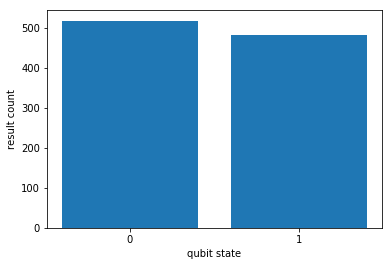

array([518., 482.])

In [274]:
results = simulator.run(test_circuit, repetitions=1000)

print('Measured Energy in Quantum Circuit {}'.format(obj_func(results)))

cirq.plot_state_histogram(results)

#A Closer Look: We Need to Tweak Current Quantum Circuit

If you take a closer look, the circuit that is shown above is not fit to apply the implemented algorithm in this notebook. We take the readout bit as the only wire we will measure to extract $P(\phi)$ to be able to optimize this system to find the optimal parameters that satisfy the halting condition of SGD. 

So, we will present below the circuit we will use to apply SGD:

In [275]:
test_circuit_label = Ising_Model_Hamiltonian_Quantum_Circuit_Label(length, h, jr, jc, xlayer_p, zlayer_p, rot_layer_p)
print('Initial Phase Parameters: ', xlayer_p, zlayer_p, rot_layer_p)
print(test_circuit_label)

Initial Phase Parameters:  0.4879698133606518 0.7707392221782763 0.4903147157900696
                               ┌──────────────┐   ┌────────┐   ┌────────┐             ┌────────┐
(0, 0): ───X^0.488───Z^0.771────X──────────────────@────────────X───────────@─────────────────────────────────────────────────────────────────────────────
                                                   │                        │
(0, 1): ───X^0.488───Z^0.771────@──────────────────┼────────────────────────@^0.771────@──────────────────────────────────────────────────────────────────
                                │                  │                                   │
(0, 2): ───X^0.488───Z^0.771────┼──────@───────────┼───────────────────────────────────@^0.771────────────────────────────────────────────────────────────
                                │      │           │
(1, 0): ───X^0.488───X──────────┼──────┼───────────@^0.771──────X───────────X──────────@───────────X───X───@─────────X────────────────

#Applying Optimization Algorithm 

Having this circuit, we can apply Adam to find the parameters that search for optimal parameters to find the appropiate quantum label.

transverse fields: [[1, 1, 1], [-1, 1, 1], [1, -1, -1]]
row j fields: [[-1, 1, 1], [-1, 1, -1]]
column j fields: [[1, 1], [-1, -1], [-1, 1]]
initial seed parameters:  0.4879698133606518 0.7707392221782763 0.4903147157900696


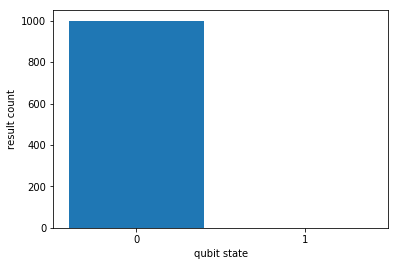

Optimal values: [0.0064732692760786255, 0.2892426780937032, 0.008818171705496387]
Done with Optimization Algorithm!


In [276]:
#let's do grad descent 
print('transverse fields: {}'.format(h))
print('row j fields: {}'.format(jr))
print('column j fields: {}'.format(jc))
print('initial seed parameters: ', xlayer_p, zlayer_p, rot_layer_p)
ising_ml_adam= Ising_Model_Params_Optimizier_Adam(length, h, jr, jc, xlayer_p, zlayer_p, rot_layer_p)

#Building Quantum Circuit with Optimized Parameters

In [277]:
test_circuit_after_optimization = Ising_Model_Hamiltonian_Quantum_Circuit_Label(length, h, jr, jc, ising_ml_adam[9][0], ising_ml_adam[9][1], ising_ml_adam[9][2])
print('Optimized Parameters: ', ising_ml_adam[9][0], ising_ml_adam[9][1], ising_ml_adam[9][2])
print(test_circuit_after_optimization)



Optimized Parameters:  0.0064732692760786255 0.2892426780937032 0.008818171705496387
                               ┌──────────────┐   ┌────────┐   ┌────────┐             ┌────────┐
(0, 0): ───X^0.006───Z^0.289────X──────────────────@────────────X───────────@─────────────────────────────────────────────────────────────────────────────
                                                   │                        │
(0, 1): ───X^0.006───Z^0.289────@──────────────────┼────────────────────────@^0.289────@──────────────────────────────────────────────────────────────────
                                │                  │                                   │
(0, 2): ───X^0.006───Z^0.289────┼──────@───────────┼───────────────────────────────────@^0.289────────────────────────────────────────────────────────────
                                │      │           │
(1, 0): ───X^0.006───X──────────┼──────┼───────────@^0.289──────X───────────X──────────@───────────X───X───@─────────X───────────────

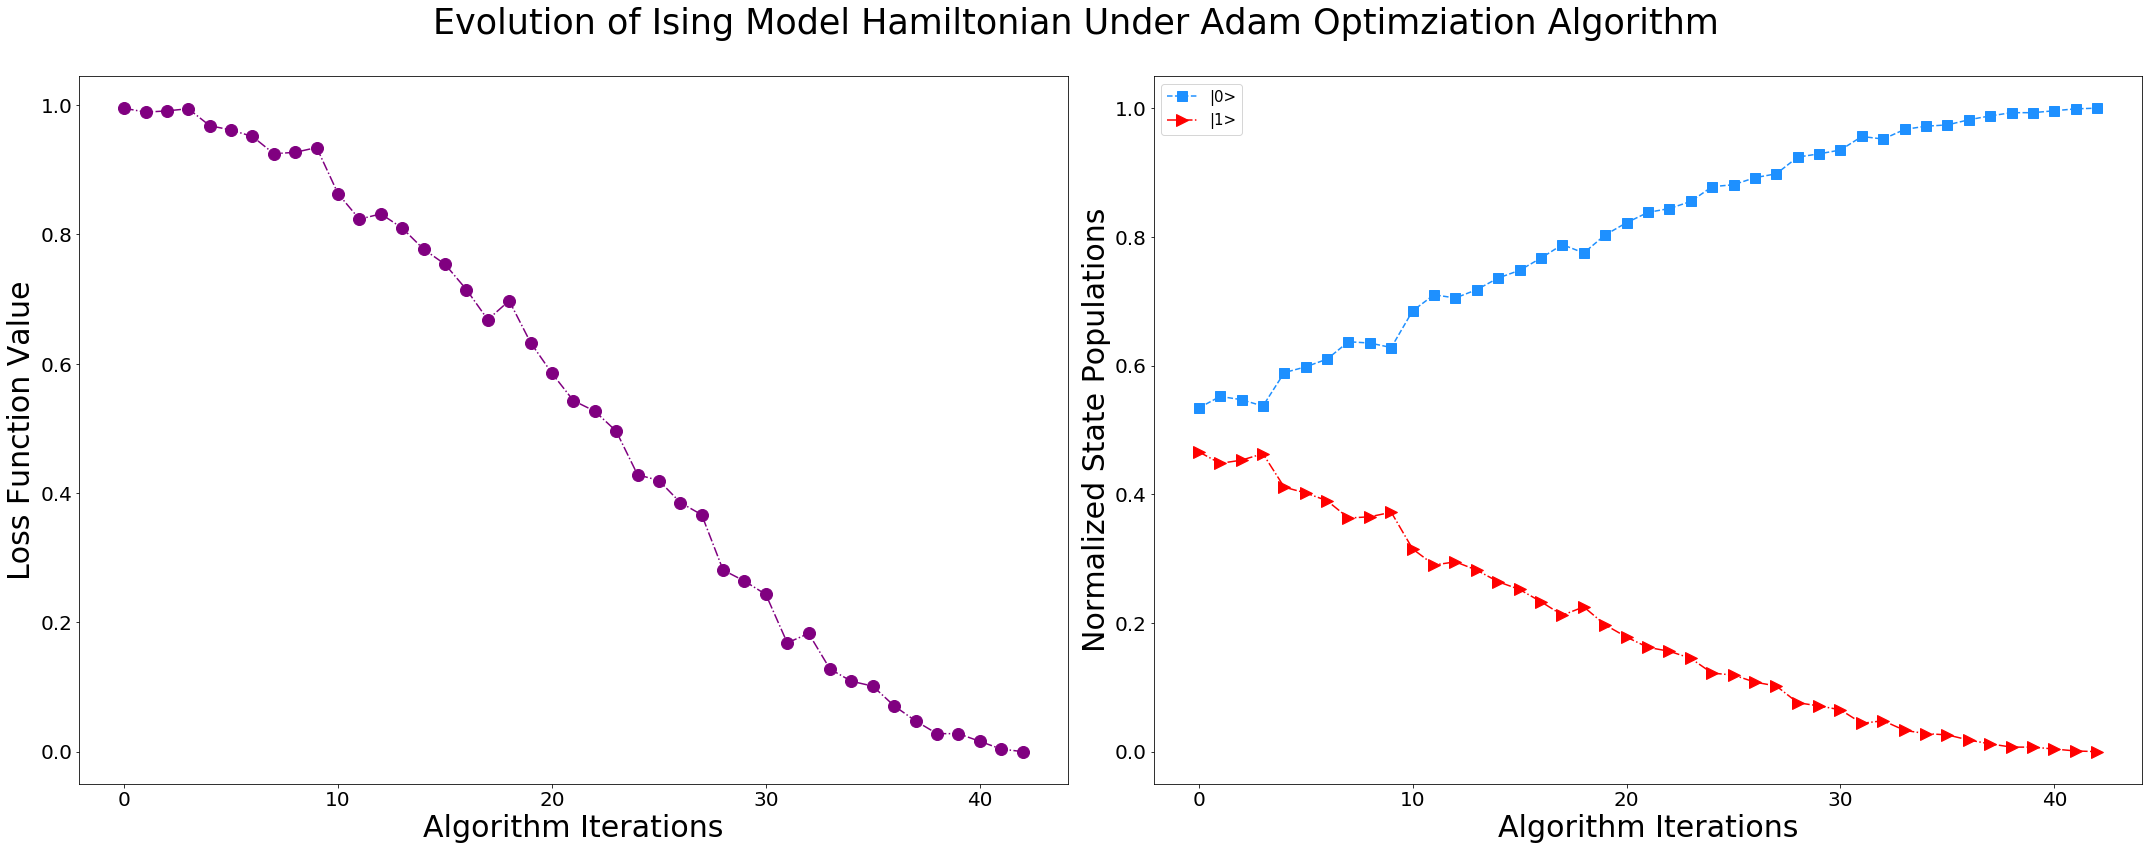

In [278]:
plot_ml_adam = plt.figure(figsize=(30,12))

plt.subplot(121)
plt.tick_params(labelsize=20)

plt.plot(ising_ml_adam[3], linestyle='-.', label='SGD-Adam', color='purple', marker='o',markersize=12)
plt.xlabel('Algorithm Iterations',fontsize=30)
plt.ylabel('Loss Function Value',fontsize=30)

plt.subplot(122)
plt.tick_params(labelsize=20)
plt.plot(ising_ml_adam[7], linestyle='--', label='|0>', marker='s', color='dodgerblue',markersize=10)
plt.plot(ising_ml_adam[8], linestyle='-.', label='|1>', marker='>', color='red',markersize=12)
plt.xlabel('Algorithm Iterations',fontsize=30)
plt.ylabel('Normalized State Populations',fontsize=30)

plt.legend(loc='best', fontsize=15)


plt.suptitle('Evolution of Ising Model Hamiltonian Under Adam Optimziation Algorithm', fontsize=35)
plt.tight_layout()
plt.subplots_adjust(top=.9)


The results above show that the same technique that proved efficient to extract and tune the Stern-Gerlach circuit to find a quantum state label can be applied to a more complex system such as the Ising Model. 

We can see the same consistency between the minimization and the corresponding quantum state. This algorithm is able to extract from a randomly seeded circuit the parameters to bring the system to a defined quantum state. 

#Bringing Optimization Algorithm to Ising Model

One of the questions that brings up this simulation work is the following: what are potential uses for this technique for other problems in quantum computing. For example, can this technique be used to test whether quantum computing outputs of problems are truly quantum? Which in the case of the Ising Model question, for the purposes of this notebook, the starting point is a randomly generated perturbation fields and gate parameters to find a quantum label. 

But what if it is a different problem: having a configuration of spins, can we extract with the randomly generated perturbatuion fields and gate parameters? 

For the purposes of this paper, we try to take one of the figures of merit used on the Cirq tutorial, the measured of energy of this quantum circuit. We know from physics principles that preferred energy state is the ground state, which has the least energy. Moreover, we know that this algorithm will find optimal parameters that yield one of this two quantum states. 

First, let's observe the evolution of the measured energy as the Adam modifies gate parameters:

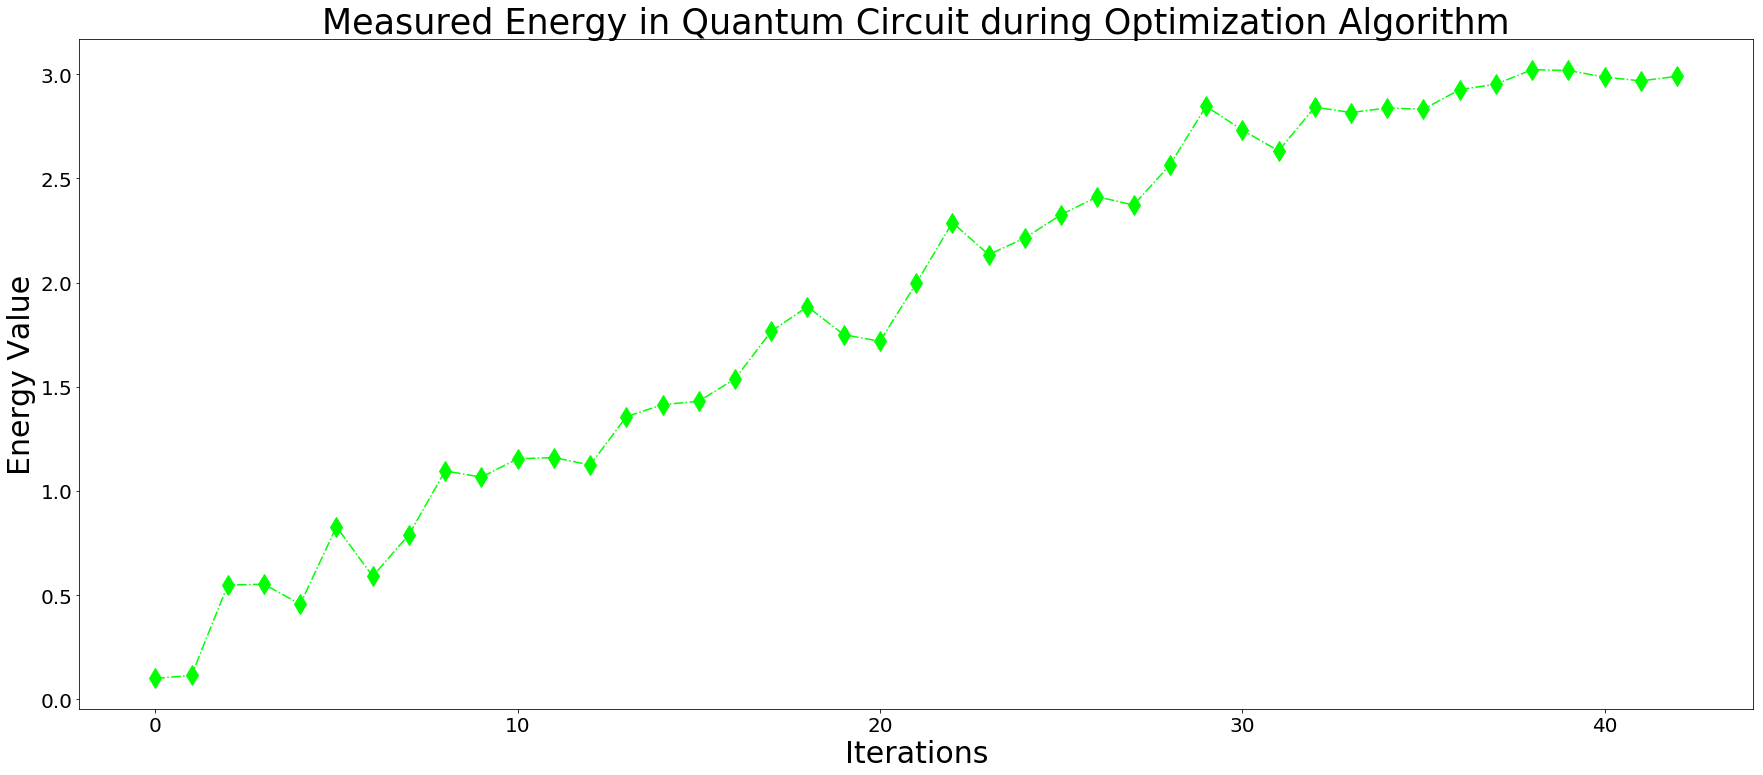

In [283]:
energy_study = plt.figure(figsize=(30,12))

plt.tick_params(labelsize=20)

plt.plot(ising_ml_adam[6], linestyle='-.', label='SGD-Adam', color='lime',marker='d', markersize=14)
plt.xlabel('Iterations',fontsize=30)
plt.ylabel('Energy Value',fontsize=30)

plt.title('Measured Energy in Quantum Circuit during Optimization Algorithm', fontsize=35)
plt.subplots_adjust(top=.9)

The following question arises: Is there a correlation between the application of this optimization algorithm, yielding a final quantum state label, and the measured energy of that circuit with the optimized parameters? 


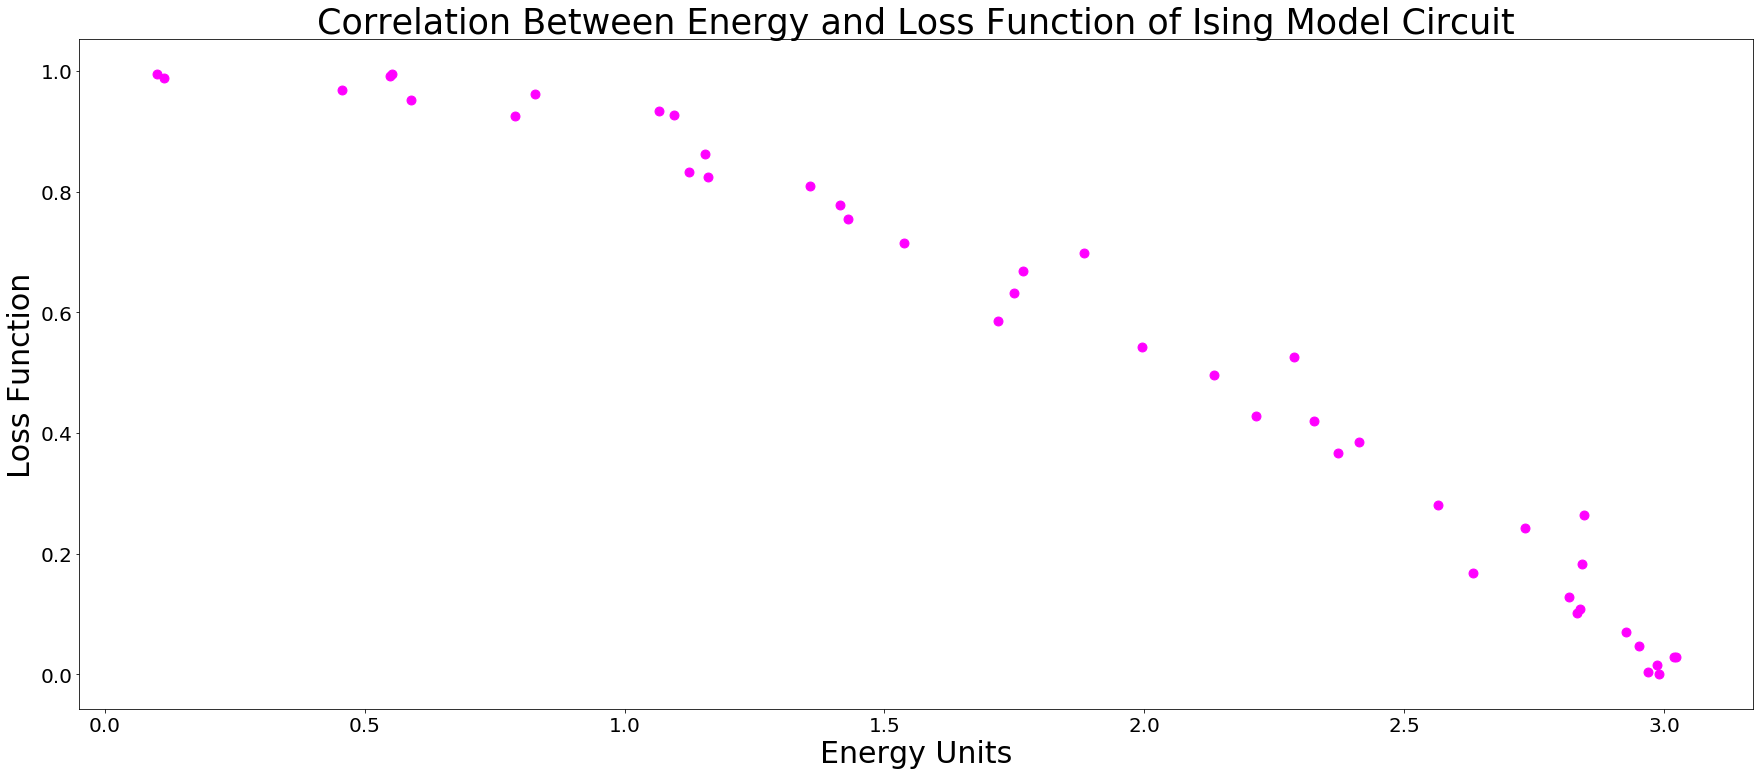

In [280]:
energy_study = plt.figure(figsize=(30,12))

coef_results = np.corrcoef(ising_ml_adam[6],ising_ml_adam[3])

#extract the element for cov(Loss, Energy) from the covariance matrix:
correlation_loss_energy = np.around(coef_results[1][0],3)

plt.scatter(ising_ml_adam[6],ising_ml_adam[3], marker='o', color='magenta', label = 'Corr: '+ str(correlation_loss_energy), s=80)
plt.tick_params(labelsize=20)

plt.xlabel('Energy Units', fontsize=30)
plt.ylabel('Loss Function', fontsize=30)
plt.title('Correlation Between Energy and Loss Function of Ising Model Circuit', fontsize=35)
#plt.legend(loc='best',fontsize=20)
plt.subplots_adjust(top=.9)


#Observations Regarding Optimization Algorithm in Ising Model Hamiltonian

I started with the hypothesis that there is a relation between the energy of a qubit and its spin state. For example, from statistical mechanics we know that a simple magnet system, the preferred spin would be one with its lowest energy - hence, the ground state.

Or, to put it in clear terms for the paper implemented in this notebook:  can the quantum state label be further validated by showing that the measured energy matches the optimzied quantum label? 

I tried to see if I could by learning one label, could also learned another, and thus use this quantum classifier to better characterize this quantum system.

Thus the following question arises: say you have N magnets, and you flip all of the magnets directions in such a way the ensemble's macrostate is the ground state. That consequence has a direct relation to the energy of the ensemble. 

In the case of this system, it's not quite the same. The readout bit is used to extract information from the state of the circuit as gate parameters are changed. However, I find that there is not a consistent correlation between the loss function and the measured energy of the system as it is being optimized. 

